In [2]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

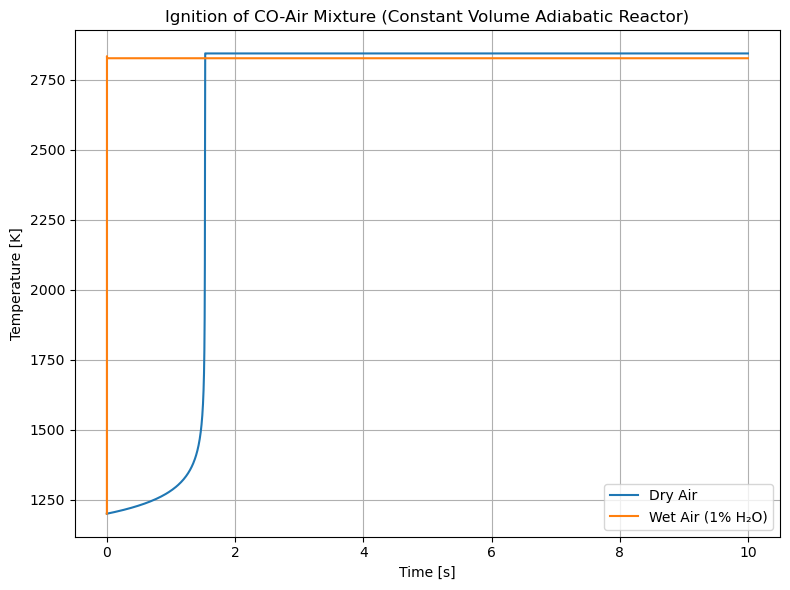

Dry Air Ignition Delay (ΔT = 600 K): 1522.33 ms
Dry Air Ignition Delay (Peak HRR):   1531.90 ms
Wet Air Ignition Delay (ΔT = 600 K): 1.13 ms
Wet Air Ignition Delay (Peak HRR):   1.13 ms


In [3]:
# -----------------------------------------------------------
# CV_Adiabatic_Reactor class definition
# -----------------------------------------------------------

class CV_Adiabatic_Reactor:
    def __init__(self, gas, volume=1, dTthresh=600):
        self.gas = gas
        self.gas.basis = 'mass'
        self.V = volume
        self.mws = self.gas.molecular_weights
        self.nTemp = 0
        self.nYstart = 1
        self.dTthresh = dTthresh

    def integrate_CV_reactor(self, T, P, fuel, oxidizer, phi, tEnd, atol=1.e-10, rtol=1.e-8):
        self.gas.set_equivalence_ratio(phi, fuel, oxidizer)
        self.gas.TP = T, P
        self.density = self.gas.density_mass
        self.M = self.density * self.V

        y = np.zeros(self.gas.n_species + 1)
        y[self.nTemp] = T
        y[self.nYstart:] = self.gas.Y

        self.soln = solve_ivp(
            fun=lambda t, y: self.computeRHS(t, y),
            t_span=[0, tEnd],
            y0=y,
            method='Radau',
            rtol=rtol,
            atol=atol
        )

        self.t = self.soln.t
        self.T = self.soln.y[self.nTemp, :]
        self.Y = self.soln.y[self.nYstart:, :]
        self.PostProcess()

    def computeRHS(self, t, y):
        dy = np.zeros(np.size(y))
        T = y[self.nTemp]
        massFrac = y[self.nYstart:]

        self.gas.set_unnormalized_mass_fractions(massFrac)
        self.gas.TD = T, self.density

        wdot = self.gas.net_production_rates
        uiBar = self.gas.partial_molar_int_energies
        ui = uiBar / self.mws
        cv = self.gas.cv_mass

        dYdt = wdot * self.mws / self.density
        dTdt = -np.sum(dYdt * ui) / cv

        dy[0] = dTdt
        dy[1:] = dYdt
        return dy

    def PostProcess(self):
        npt = len(self.soln.t)
        self.P = np.zeros(npt)
        self.HeatRelease = np.zeros(npt)

        self.tIgn_dT = 1.e10
        To = self.T[0]
        Tcheck = To + self.dTthresh
        flag = False

        for i in range(npt):
            self.gas.TDY = self.T[i], self.density, self.Y[:, i]
            self.P[i] = self.gas.P
            self.HeatRelease[i] = -np.sum(self.gas.net_production_rates *
                                          self.gas.partial_molar_int_energies)

            if (self.T[i] > To + self.dTthresh):
                flag = True
            if flag:
                if (self.T[i - 1] < Tcheck and self.T[i] >= Tcheck):
                    tIgn = self.t[i - 1] + \
                           (self.t[i] - self.t[i - 1]) * \
                           (Tcheck - self.T[i - 1]) / (self.T[i] - self.T[i - 1])
                    self.tIgn_dT = tIgn

        iHRmax = np.argmax(self.HeatRelease)
        self.tIgn_HR = self.t[iHRmax]

# -----------------------------------------------------------
# Main script
# -----------------------------------------------------------

def main():
    # Initial conditions
    T0 = 1200.0          # K
    P0 = ct.one_atm      # Pa
    phi = 1.0            # stoichiometric
    tEnd = 10.0           # seconds

    # Fuel and oxidizers
    fuel = 'CO:1'
    oxidizer_dry = 'O2:1, N2:3.76'
    oxidizer_wet = 'O2:0.208, N2:0.782, H2O:0.01'  # 1% H2O by volume

    # Create gas objects
    gas_dry = ct.Solution('gri30.yaml')
    gas_wet = ct.Solution('gri30.yaml')

    # Reactors
    CV_dry = CV_Adiabatic_Reactor(gas_dry, volume=1.0)
    CV_wet = CV_Adiabatic_Reactor(gas_wet, volume=1.0)

    # Simulations
    CV_dry.integrate_CV_reactor(T0, P0, fuel, oxidizer_dry, phi, tEnd)
    CV_wet.integrate_CV_reactor(T0, P0, fuel, oxidizer_wet, phi, tEnd)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(CV_dry.t, CV_dry.T, label='Dry Air')
    plt.plot(CV_wet.t, CV_wet.T, label='Wet Air (1% H₂O)')
    plt.xlabel('Time [s]')
    plt.ylabel('Temperature [K]')
    plt.title('Ignition of CO-Air Mixture (Constant Volume Adiabatic Reactor)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Results
    print(f'Dry Air Ignition Delay (ΔT = 600 K): {CV_dry.tIgn_dT * 1000:.2f} ms')
    print(f'Dry Air Ignition Delay (Peak HRR):   {CV_dry.tIgn_HR * 1000:.2f} ms')
    print(f'Wet Air Ignition Delay (ΔT = 600 K): {CV_wet.tIgn_dT * 1000:.2f} ms')
    print(f'Wet Air Ignition Delay (Peak HRR):   {CV_wet.tIgn_HR * 1000:.2f} ms')

if __name__ == '__main__':
    main()

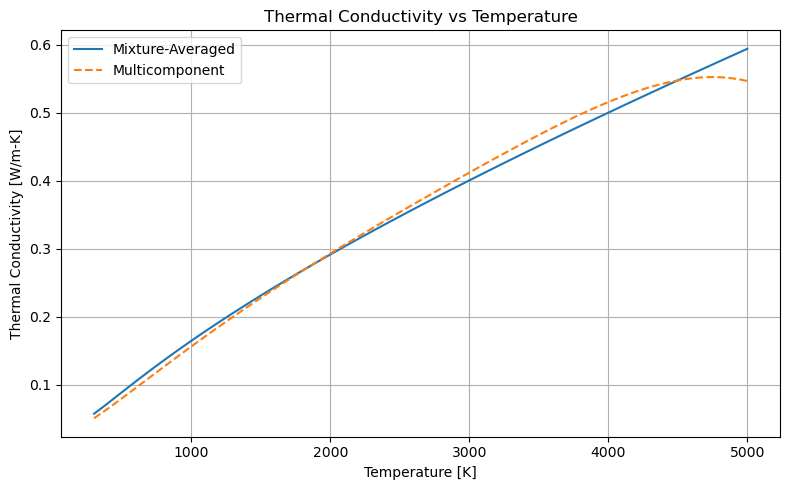

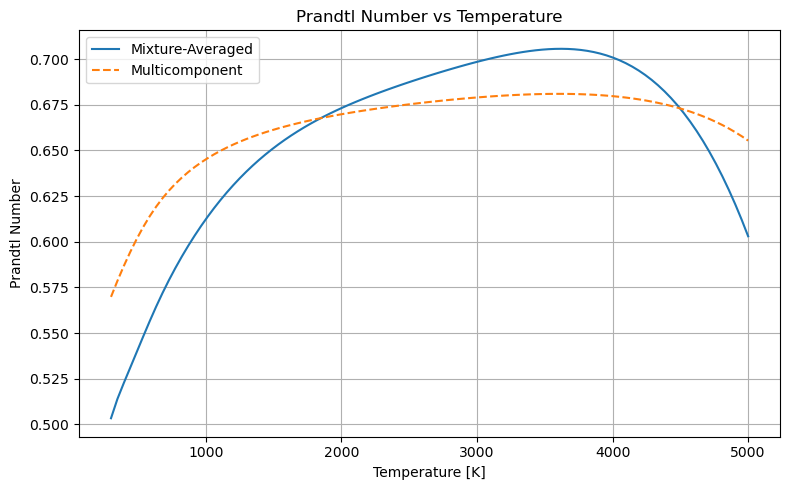

In [4]:
full_gas = ct.Solution('CRECK.yaml')
species_names = ['He', 'O2', 'CH4']
species_list = [full_gas.species(name) for name in species_names]
gas = ct.Solution(thermo='ideal-gas', species=species_list, kinetics=None)


T_range = np.linspace(300, 5000, 100)  # reduced points for speed
P = ct.one_atm


k_mix = []
k_multi = []
Pr_mix = []
Pr_multi = []


X = 'He:1, O2:1, CH4:1'


for T in T_range:
    gas.TPX = T, P, X

    # Mixture-averaged
    gas.transport_model = 'mixture-averaged'
    mu_mix = gas.viscosity
    cp_mix = gas.cp_mass
    k_mix_val = gas.thermal_conductivity
    Pr_mix_val = mu_mix * cp_mix / k_mix_val

    # Multicomponent
    gas.transport_model = 'multicomponent'
    mu_multi = gas.viscosity
    cp_multi = gas.cp_mass
    k_multi_val = gas.thermal_conductivity
    Pr_multi_val = mu_multi * cp_multi / k_multi_val

    # Store
    k_mix.append(k_mix_val)
    k_multi.append(k_multi_val)
    Pr_mix.append(Pr_mix_val)
    Pr_multi.append(Pr_multi_val)

# Plot thermal conductivity
plt.figure(figsize=(8, 5))
plt.plot(T_range, k_mix, label='Mixture-Averaged')
plt.plot(T_range, k_multi, label='Multicomponent', linestyle='--')
plt.xlabel('Temperature [K]')
plt.ylabel('Thermal Conductivity [W/m-K]')
plt.title('Thermal Conductivity vs Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Prandtl number
plt.figure(figsize=(8, 5))
plt.plot(T_range, Pr_mix, label='Mixture-Averaged')
plt.plot(T_range, Pr_multi, label='Multicomponent', linestyle='--')
plt.xlabel('Temperature [K]')
plt.ylabel('Prandtl Number')
plt.title('Prandtl Number vs Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()